# Property predictions using 3D conformer geometries

This tutorial takes you through 3D-based property predictions. The `README` in `cp3d/scripts` gives an in-depth description of how to run the necessary scripts, while this tutorial is more focused on exploring what goes on behind the scripts.

#### Some preliminaries
Automatically reload any changes made to files:

In [1]:
%load_ext autoreload
%autoreload 2

Make sure that `nff` is in your path:

In [2]:
import sys

sys.path.insert(0, "..")
sys.path.insert(0, "../..")

# Making a dataset

To make a dataset we'll need two things. First, we need a folder consisting of pickle files, one for each species. Second we'll need a `JSON` file that summarizes the information about each of the species. 

This tutorial will use the `GEOM` dataset as an example. To follow along, download the file `rdkit_folder.tar.gz` from [this page](https://www.dropbox.com/sh/1aptf9fi8kyrzg6/AABQ4F7dpl4tQ_pGCf2izd7Ca?dl=0). Untar the file by running
```
tar -xzvf rdkit_folder.tar.gz
```
in the command line. This should generate a folder called rdkit_folder. We'll start by getting familiar with the contents of this folder.



## Getting acquainted with the pickle folder

We'll define `pickle_folder` as the full path to this RDKit folder, and `summary_path` as the full path to the summary file:



In [3]:
import os

# change to wherever you have downloaded the zip file
directory = "/home/saxelrod/rgb_nfs/GEOM_DATA_ROUND_2"

rd_folder = os.path.join(directory, "rdkit_folder")
summary_path = os.path.join(rd_folder, "summary_drugs.json")

You can find more information about the structure of the GEOM dataset and loading the files [here](https://github.com/learningmatter-mit/geom). For now we'll take a quick look at the summary file and a sample pickle file.

First we'll load the summary dictionary:

In [4]:
import json
with open(summary_path, "r") as f:
    summary = json.load(f)

Now let's look at a sample SMILES string:

In [5]:
smiles = list(summary.keys())[10078]
print(smiles)
dic = summary[smiles]
dic

CC(=O)N1CCN(C(=O)CCl)CC1


{'charge': 0,
 'datasets': ['mpro_xchem'],
 'ensembleenergy': 0.224,
 'ensembleentropy': 5.131,
 'ensemblefreeenergy': -1.53,
 'lowestenergy': -42.33811,
 'pickle_path': 'drugs/CC(=O)N1CCN(C(=O)CCl)CC1.pickle',
 'poplowestpct': 66.181,
 'sars_cov_two_cl_protease_active': 1,
 'temperature': 298.15,
 'totalconfs': 67,
 'uniqueconfs': 16}

Say we want to create a dataset for a set of species with the known property `sars_cov_two_cl_protease_active`. Then the most important two things in this dictionary are the value of `sars_cov_two_cl_protease_active`, and the key `pickle_path`, which tells us where to find the associated pickle file with 3D conformer information.

Let's load the associated pickle file and take a look at it:

In [6]:
import pickle

pickle_path = os.path.join(rd_folder, dic['pickle_path'])
with open(pickle_path, "rb") as f:
    conf_dic = pickle.load(f)

The key `conformer` gives a list of dictionaries, one for each conformer. The most important part of that dictionary is `rd_mol`, and RDKit `mol` object. This `mol` object contains 3D information as well as bond information. It will allow us to create our dataset for training.

{'geom_id': 133329555,
 'set': 4,
 'degeneracy': 6,
 'totalenergy': -42.33411442,
 'relativeenergy': 2.505,
 'boltzmannweight': 0.00968,
 'conformerweights': [0.00161, 0.00161, 0.00161, 0.00161, 0.00161, 0.00161],
 'rd_mol': <rdkit.Chem.rdchem.Mol at 0x7fb1a077ccf0>}

Statistical weight: 9.68e-03


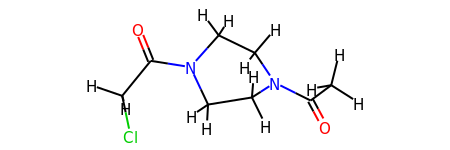

Statistical weight: 7.07e-03


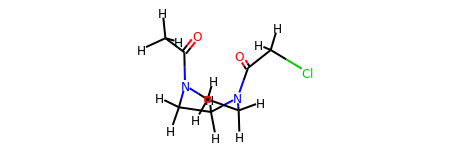

Statistical weight: 2.42e-03


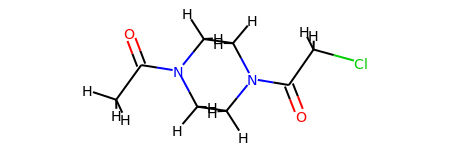

Statistical weight: 7.20e-04


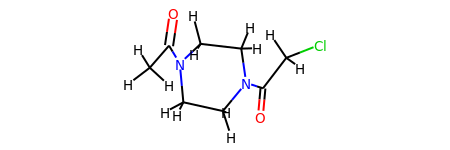

Statistical weight: 2.40e-04


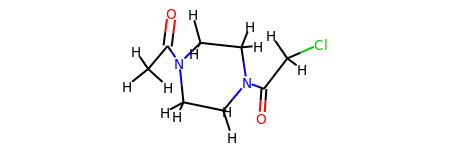

Statistical weight: 1.70e-04


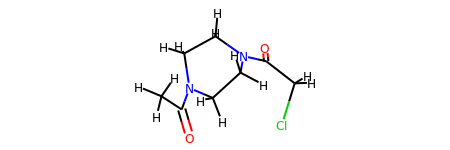

Statistical weight: 1.60e-04


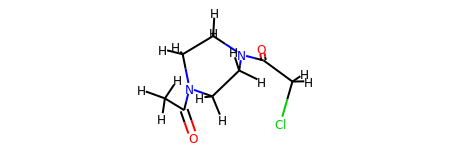

Statistical weight: 4.00e-05


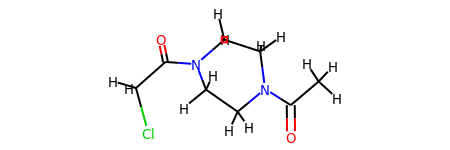

Statistical weight: 2.00e-05


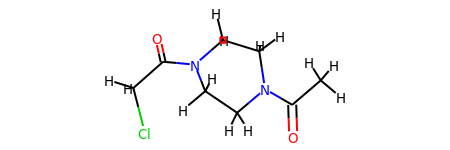

Statistical weight: 8.00e-05


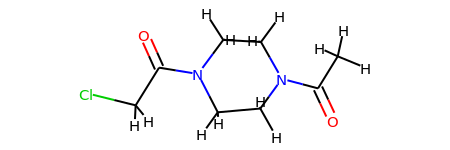

Statistical weight: 2.00e-05


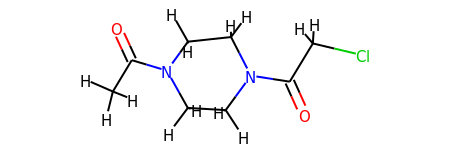

Statistical weight: 5.00e-05


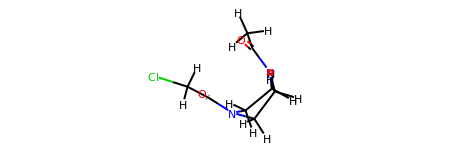

Statistical weight: 5.00e-05


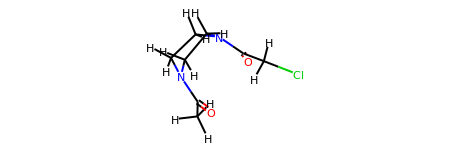

Statistical weight: 6.62e-01


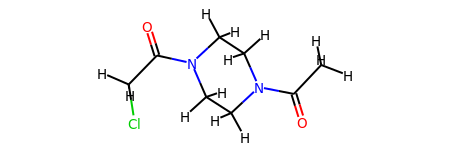

Statistical weight: 3.07e-01


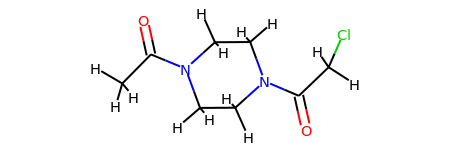

Statistical weight: 1.08e-02


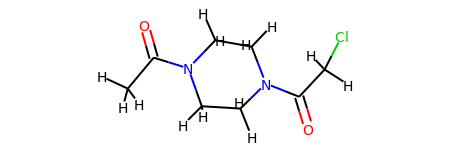

In [7]:
display(conf_dic["conformers"][0])
for conf in conf_dic["conformers"]:
    weight = conf["boltzmannweight"]
    print("Statistical weight: %.2e" % weight)
    display(conf["rd_mol"])

## Generating training splits

Now that we have a pickle folder with pickle files and a summary, let's navigate to `scripts/cp3d/make_dset/splits` to generate training splits. 

First we'll want to modify the config file, `split_config.json`. A detailed description of the keys can be found in the `README` file. The most important things for us are `summary_path`, which we've located, `csv_folder`, the folder in which we want to save our splits, and `props`, the properties we'll want to predict (`sars_cov_two_cl_protease_active` for us).

Now let's run the script itself:
```
cd ../scripts/cp3d/make_dset/splits
bash splits.sh
```

Your output should look something like this:

```
100%|███████████████████████████████████████████████████████████████████| 816/816 [00:00<00:00, 8496.42it/s]
100%|███████████████████████████████████████████████████████████████████| 816/816 [00:00<00:00, 917082.55it/s]
100%|███████████████████████████████████████████████████████████████████| 816/816 [00:00<00:00, 15146.78it/s]
Splits saved in /home/saxelrod/chemprop_cov_2/scaffold_split
Train files: train_smiles.csv and train_full.csv (489 species, 49 positives)
Validation files: val_smiles.csv and val_full.csv (163 species, 13 positives) 
Test files: test_smiles.csv and test_full.csv (164 species, 16 positives)
Combined file: all.csv (816 species, 78 positives)
```

We see that the script has generated CSV files with dataset splits for us, finding a total of 816 species with the property we want, including 78 hits. In this example we've used a scaffold split, so that the different sets do not have molecules that share a scaffold. We can see that the files are saved in `/home/saxelrod/chemprop_cov_2/scaffold_split`:

In [8]:
# change to your folder
csv_folder = "/home/saxelrod/chemprop_cov_2/scaffold_split"
os.listdir(csv_folder)

['train_full.csv',
 'all.csv',
 'val_full.csv',
 'test_full.csv',
 'test_smiles.csv',
 'train_smiles.csv',
 'val_smiles.csv']

## Creating the dataset from the pickle files and the splits

Now that we've created splits, we can use the splits together with the pickle files to generate a dataset. To do so, we run

```
cd ../scripts/cp3d/make_dset/get_dset
bash dset_from_pickles.sh

```

on the command line. The details for this job are in `make_dset/dset_config.json`, and are described in detail in the `README`. Here we choose to save the dataset in two chunks. Running the script should give something like this:

```
DeprecationWarning: 'source deactivate' is deprecated. Use 'conda deactivate'.
python dset_from_pickles.py --thread 0 --config_file dset_config.json
Loading splits...
Loading data from pickle files...
100%|█████████████████████████████████████████████████████████████████| 408/408 [00:04<00:00, 99.05it/s]
Converting data...
Combining to make NFF dataset...
Making dataset with 408 species
100%|█████████████████████████████████████████████████████████████████| 408/408 [00:05<00:00, 74.18it/s]
Featurizing dataset with 1 parallel process.
Featurizing bonds...
100%|█████████████████████████████████████████████████████████████████| 408/408 [00:23<00:00, 17.29it/s]
Featurizing atoms...
100%|█████████████████████████████████████████████████████████████████| 408/408 [00:34<00:00, 11.67it/s]
Complete!
Creating test/train/val splits...
Saving...
Complete!
python dset_from_pickles.py --thread 1 --config_file dset_config.json
Loading splits...
Loading data from pickle files...
100%|█████████████████████████████████████████████████████████████████| 408/408 [00:04<00:00, 100.79it/s]
Converting data...
Combining to make NFF dataset...
Making dataset with 408 species
100%|█████████████████████████████████████████████████████████████████| 408/408 [00:05<00:00, 76.42it/s]
Featurizing dataset with 1 parallel process.
Featurizing bonds...
100%|█████████████████████████████████████████████████████████████████| 408/408 [00:23<00:00, 17.65it/s]
Featurizing atoms...
100%|█████████████████████████████████████████████████████████████████| 408/408 [00:32<00:00, 12.65it/s]
Complete!
Creating test/train/val splits...
Saving...
Complete!
```


This is pretty quick for our small dataset with only 816 species. But for a big dataset (e.g. for SARS-CoV, which has 289,000 species), it can take much longer. We recommend running the script in `tmux` so that it can go on in the background, or submitting it as a job on a cluster.

The datasets are saved in the folder `dataset_folder` specified in the `dset_config.json` file. Let's see what these folders look like:

![alt text](dset_folder.png "Title")

We see that two folders have been created, one for each dataset split. Each folder contains its own training, validation, and test splits. This division of datasets is useful if the dataset is too large to be loaded into memory on its own (this is the case with the SARS-CoV dataset). 

If you save the dataset into `N` separate folders, then when you train over `M` different GPUs, it will load data from the first `M` folders. That means that if you separate it into 4 folders and train over 4 GPUs, you will be training on the whole dataset. But if you divide it into 8 folders and train on 4 GPUs, you will only be training on half the dataset. Finally, if you don't divide the dataset, and store it in `<model_path>` (rather than `<model_path/0>`, you can train on as many GPUs as you want.

## Getting acquainted with the dataset

Now that we have our datasets, let's see what they actually look like and what they can do. First let's load one: 

In [9]:
from nff.data import Dataset

# change to your folder
dset_folder = "/home/saxelrod/rgb_nfs/models/cov_1_combined"

train_0_path = os.path.join(dset_folder, "0/train.pth.tar")
train_0 = Dataset.from_file(train_0_path)

The defining attribute of a dataset is `props`, its dictionary of properties:

In [10]:
props = train_0.props
props.keys()

dict_keys(['set', 'lowestenergy', 'nxyz', 'charge', 'geom_id', 'ensembleentropy', 'temperature', 'mol_size', 'degeneracy', 'ensemblefreeenergy', 'ensembleenergy', 'totalenergy', 'weights', 'sars_cov_one_cl_protease_active', 'smiles', 'num_atoms', 'pseudomonas_active', 'sars_cov_two_active', 'sars_cov_one_pl_protease_active', 'ecoli_inhibitor', 'energy', 'uniqueconfs', 'sars_cov_two_cl_protease_active', 'poplowestpct', 'nbr_list', 'rd_mols', 'bond_features', 'num_bonds', 'atom_features', 'bonded_nbr_list'])

These keys can be more or less divided into four categories:
1. Properties you want to predict
2. Extra properties that you don't care about
3. Species attributes that are used to predict properties
4. Auxiliary properties used to help in training

Many of the keys fall into category 2 (`totalenergy`, `uniqueconfs`, etc.). As for category 1, here we're interested in `sars_cov_two_cl_protease_active`. Most molecules are inactive, but some are active:


In [11]:
props['sars_cov_two_cl_protease_active']

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1])

Category 3 includes `atom_features` (graph-based atomic features), `bond_features` (graph-based bond features), and `nxyz` (geometry of the conformers):

In [12]:
display(props['atom_features'][3])
display(props['nxyz'][3])
display(props["uniqueconfs"][3])

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1201],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0101],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0101],
        ...,
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0101],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0101],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0101]])

tensor([[ 6.0000e+00,  1.0495e+00,  7.6908e-01,  7.0728e-02],
        [ 1.0000e+00,  1.3701e+00,  1.1573e+00,  1.0379e+00],
        [ 1.0000e+00,  1.7066e+00,  1.1806e+00, -6.9271e-01],
        [ 6.0000e+00, -4.2569e-01,  1.1427e+00, -1.9671e-01],
        [ 7.0000e+00, -1.2258e+00,  4.1912e-04,  2.1413e-01],
        [ 1.0000e+00, -1.3129e+00,  3.9571e-04,  1.2275e+00],
        [ 6.0000e+00, -4.2650e-01, -1.1424e+00, -1.9683e-01],
        [ 1.0000e+00, -7.4083e-01, -2.0463e+00,  3.2343e-01],
        [ 6.0000e+00,  1.0489e+00, -7.6983e-01,  7.0882e-02],
        [ 1.0000e+00,  1.3689e+00, -1.1581e+00,  1.0383e+00],
        [ 1.0000e+00,  1.7059e+00, -1.1821e+00, -6.9233e-01],
        [ 1.0000e+00, -5.8688e-01, -1.2844e+00, -1.2697e+00],
        [ 1.0000e+00, -7.3929e-01,  2.0467e+00,  3.2378e-01],
        [ 1.0000e+00, -5.8613e-01,  1.2850e+00, -1.2696e+00],
        [ 6.0000e+00,  1.0396e+00,  7.7037e-01,  6.2637e-02],
        [ 1.0000e+00,  1.3653e+00,  1.1501e+00,  1.0292e+00],
        

tensor(2)

The atom features and xyz coordinates are a set of `N` vectors, where `N` is the total number of atoms when of *all conformers*:

In [13]:
print(props['atom_features'][4].shape)
print(props['nxyz'][4].shape)

# mol_size is the number of atoms in one conformer
print((props["uniqueconfs"][4] * props["mol_size"][4]).item())


torch.Size([250, 133])
torch.Size([250, 4])
250


By having `mol_size` (the number of atoms in one conformer) as a property, we can easily split these into per-conformer properties:

In [14]:
import torch

nxyz = props['nxyz'][4]
mol_size = props["mol_size"][4].item()
num_confs = nxyz.shape[0] // mol_size

nxyz_by_conformer = torch.split(props['nxyz'][4], [mol_size] * num_confs)
len(nxyz_by_conformer)

10

Category 4 includes keys like `nbr_list` and `bonded_nbr_list`. Each of these is a set of pairs that tell you which atoms are within 5 Angstroms of each other, or bonded to each other, respectively:

In [15]:
props['nbr_list'][4][:10]

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 17]])

In [16]:
props['bonded_nbr_list'][4][:10]

tensor([[ 0,  1],
        [ 0, 22],
        [ 0, 23],
        [ 0, 24],
        [ 1,  2],
        [ 1,  3],
        [ 3,  4],
        [ 3, 18],
        [ 4,  5],
        [ 4,  9]])

## Adding extra features

We can also add extra features to the dataset, like Morgan fingerprints. Here we add Morgan fingerprints of size 100:

In [17]:
train_0.add_morgan(100)

print(train_0.props["morgan"][4])

tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 0.])


We can add 3D features, like WHIM or 3D autocorrelations:

In [18]:
# add whim descriptors
train_0.featurize_rdkit('whim')

# add autocorrelation_3d descriptors
train_0.featurize_rdkit('autocorrelation_3d')


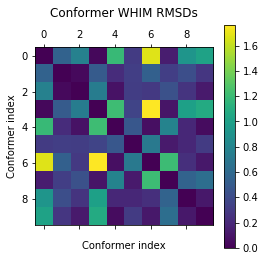

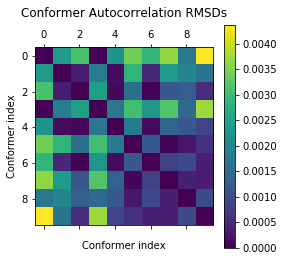

In [19]:
import numpy as np
from matplotlib import pyplot as plt


# look at the RMSDS betwene conformers of species 2

whims = train_0.props['whim'][4]
autcorr = train_0.props['autocorrelation_3d'][4]

num_fps = whims.shape[0]

whim_rmsds = ((whims.expand(num_fps, num_fps, -1) 
              - whims.expand(num_fps, num_fps, -1).transpose(0, 1)) ** 2).mean(-1)

corr_rmsds = ((autcorr.expand(num_fps, num_fps, -1) 
              - autcorr.expand(num_fps, num_fps, -1).transpose(0, 1)) ** 2).mean(-1)

plt.matshow(whim_rmsds)
plt.colorbar()
plt.xlabel("\nConformer index")
plt.ylabel("Conformer index")
plt.title("Conformer WHIM RMSDs\n")
plt.show()

plt.matshow(corr_rmsds)
plt.colorbar()
plt.xlabel("\nConformer index")
plt.ylabel("Conformer index")
plt.title("Conformer Autocorrelation RMSDs\n")
plt.show()





We can add E3FP fingerprints, which contain both 3D and graph information (note: using `num_procs > 1` seems to have issues on some computers. Creating the fingerprints with one processor takes a few minutes for this dataset, so you can comment out these cells to avoid slowing down the tutorial.)

In [20]:
train_0.add_e3fp(256, num_procs=1)

Adding E3P fingerprints with 1 parallel process.


100%|██████████| 272/272 [05:36<00:00,  1.24s/it]


We can plot RMSDs for E3FP as well:

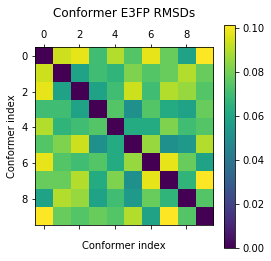

In [21]:
e3fp = train_0.props['e3fp'][4]
e3fp_rmsds = ((e3fp.expand(num_fps, num_fps, -1) 
              - e3fp.expand(num_fps, num_fps, -1).transpose(0, 1)) ** 2).mean(-1)


plt.matshow(e3fp_rmsds)
plt.colorbar()
plt.xlabel("\nConformer index")
plt.ylabel("Conformer index")
plt.title("Conformer E3FP RMSDs\n")
plt.show()



# Training a model

The script for training a model is `cp3d/train/train_parallel.sh`. Details about the config file, parallelizing over GPUs, submitting to a cluster, and so on can be found in the README file. When it comes to running the script it is most helpful to use the README file. Here we'll look at some of what goes on underneath the hood of the scripts, so that you have a better understanding of the process.


## Making a model and seeing how it works
Let's first look at creating the model. For this we'll use some of the parameters in the config file:


In [22]:
morgan_len = 100
whim_len = 114

modelparams =  {
    
        "model_type": "SchNetFeatures",

        "mol_basis": 300,
        "cp_dropout": 0.02,
        "schnet_dropout": 0.2,
        "activation": "ReLU",
        "n_atom_basis": 133,
        "n_bond_features": 26,
        "n_bond_hidden": 300,
        "n_convolutions": 2,
        "n_filters": 64,
        "n_gaussians": 10,
        "cutoff": 5.0,

        "input_layers": [
            {
                "name": "linear",
                "param": {
                    "in_features": 159,
                    "out_features": 300
                }
            },
            {
                "name": "ReLU",
                "param": {}
            }
        ],

        "output_layers": [
            {
                "name": "linear",
                "param": {
                    "in_features": 497,
                    "out_features": 300
                }
            },
            {
                "name": "ReLU",
                "param": {}
            }
        ],

        "mol_fp_layers": [],

        "boltzmann_dict": {
            "boltz_basis": 10,
            "dropout_rate": 0.1,
            "final_act": "ReLU",
            "head_pool": "concatenate",
            
            # add the length of the whim fingerprint
            # here, as it will be concatenated with the
            # learned 3D fingerprint
            
            "mol_basis": (300 + whim_len),
            "num_heads": 3,
            "type": "linear_attention"
        },


        "readoutdict": {
            "sars_cov_two_cl_protease_active": [
                {
                    "name": "linear",
                    "param": {
                        
                        # add the length of the whim fingerprint
                        # since it gets concatenated with the learned fingerprint,
                        # and multiply the total by 3 for 3 heads. Then add
                        # the Morgan fingerprint length at the end (only one
                        # for the whole species, so not multiplied by 3)
                        
                        "in_features": (300 + whim_len ) * 3 + morgan_len,
                        "out_features": 450
                    }
                },
                {
                    "name": "Dropout",
                    "param": {
                        "p": 0.02
                    }
                },
                {
                    "name": "ReLU",
                    "param": {}
                },
                {
                    "name": "linear",
                    "param": {
                        "in_features": 450,
                        "out_features": 1
                    }
                },
                {
                    "name": "Dropout",
                    "param": {
                        "p": 0.02
                    }
                }
            ]
        },
    
        "classifier": True,
        "gauss_embed": True,
        "same_filters": True,
        "trainable_gauss": False,
        "base_keys": ["sars_cov_two_cl_protease_active"],
        "grad_keys": [],
    
        "extra_features": ["whim", "morgan"],
        "ext_feat_types": ["conformer", "species"],
    
        "use_mpnn": True
    
}


For this demonstration we've changed the `extra_features` and `extra_feat_types` parameters from the config file. Before they were set to `None`, but here we add Whim and Morgan fingerprints to show how you can add non-learned fingerprints in training. We set `extra_features` to `["whim", "morgan"]`, and  `ext_feat_types` to `["conformer", "species"]`, meaning that the whim fingerprint applies to conformers separately, and Morgan to the entire species.

We've also changed some input dimensions in the layers. The pooling dictionary `boltzmann_dict` now pools molecular fingerprints of size `(300 + whim_len)`, as the learned fingerprint gets concatenated with the whim fingerprint. And the readout dictionary also acquires the length of the Morgan fingerprint. Three attention heads leads to an input dimension of size `(300 + whim_len ) * 3 + morgan_len`.

Now we create a model with these parameters:

In [23]:
from nff.train import get_model
import torch

torch.manual_seed(0)
model = get_model(params=modelparams,
                  model_type=modelparams["model_type"])

Here's what the model looks like:

In [24]:
model

SchNetFeatures(
  (convolutions): ModuleList(
    (0): CpSchNetConv(
      (dense): Dense(
        in_features=300, out_features=300, bias=False
        (dropout): Dropout(p=0.02, inplace=False)
      )
      (activation): ReLU()
      (moduledict): ModuleDict(
        (edge_filter): Sequential(
          (0): GaussianSmearing()
          (1): Dense(
            in_features=10, out_features=64, bias=True
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (2): ReLU()
        )
      )
    )
    (1): CpSchNetConv(
      (dense): Dense(
        in_features=300, out_features=300, bias=False
        (dropout): Dropout(p=0.02, inplace=False)
      )
      (activation): ReLU()
      (moduledict): ModuleDict(
        (edge_filter): Sequential(
          (0): GaussianSmearing()
          (1): Dense(
            in_features=10, out_features=64, bias=True
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (2): ReLU()
        )
      )
    )
  )
  (m

The input module `W_i` first converts the concatenation of atomic features with edge features into hidden edge vectors:

In [25]:
model.W_i # dimension (133 + 26 x 300)

ChemPropInit(
  (input): Sequential(
    (linear0): Linear(in_features=159, out_features=300, bias=False)
    (ReLU1): ReLU()
  )
)

The model then consists of two convolutions to generate atomic fingerprints. Each convolution involves a dense (linear) layer with dropout acting on the atomic features, a Gaussian smearing layre for the distances, and a dense layer to conver them to dimension 64. These edge features are then concatenated and updated. You can look at the source code for `CpSchNetConv` (in `nff/modules.py`) for more details.

In [26]:
print(len(model.convolutions))
model.convolutions[0]

2


CpSchNetConv(
  (dense): Dense(
    in_features=300, out_features=300, bias=False
    (dropout): Dropout(p=0.02, inplace=False)
  )
  (activation): ReLU()
  (moduledict): ModuleDict(
    (edge_filter): Sequential(
      (0): GaussianSmearing()
      (1): Dense(
        in_features=10, out_features=64, bias=True
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): ReLU()
    )
  )
)

The edge vectors are turned back into atomic feature vectors before summation through `W_o`:

In [27]:
model.W_o # dimension (133 + 64 + 300 x 300)

ChemPropMsgToNode(
  (output): Sequential(
    (linear0): Linear(in_features=497, out_features=300, bias=False)
    (ReLU1): ReLU()
  )
)

Next an empty set of layers `mol_fp_nn` acts on the sum of the atomic fingerprints (this is necessary if the atomic fingerprints have a different dimension than the desired dimension for the molecular fingeprint). 

`boltz_nns` is a set of three linear attention modules to pool the fingerprints together:

In [28]:
print(len(model.boltz_nns))

# layer to convert boltzmann weight to vector
print(model.boltz_nns[0].boltz_lin)

# activation function that follows
print(model.boltz_nns[0].boltz_act)

# linear layer to convert cat([fingerprint, boltz_vec])
# back to original dimension
print(model.boltz_nns[0].fp_linear)

# linear layer applied to this fingerprint
print(model.boltz_nns[0].W)

# numbers that multiply W.fp before getting summed and turned into
# weights through a softmax

print(model.boltz_nns[0].att_weight.shape)

3
Linear(in_features=1, out_features=10, bias=True)
Softmax(dim=1)
Linear(in_features=424, out_features=414, bias=False)
Linear(in_features=414, out_features=414, bias=True)
torch.Size([1, 414])


The readout module converts the concatenation of the three sets of pooled fingerprints into a prediction. **Caution**: do not add a sigmoid layer for a classifier. This will automatically be added in `eval` mode and automatically **not added** when in `train` mode. This allows us to use the more stable logits cross entropy loss in train mode.

In [29]:
model.readout

NodeMultiTaskReadOut(
  (readout): ModuleDict(
    (sars_cov_two_cl_protease_active): Sequential(
      (linear0): Linear(in_features=1342, out_features=450, bias=True)
      (Dropout1): Dropout(p=0.02, inplace=False)
      (ReLU2): ReLU()
      (linear3): Linear(in_features=450, out_features=1, bias=True)
      (Dropout4): Dropout(p=0.02, inplace=False)
    )
  )
)

We can make a data loader to sample a batch from the dataset and apply our model to it. We can use a custom balanced sampler to make sure we get approximately equal amounts of positive and negative binders:

In [30]:
from nff.data import collate_dicts
from torch.utils.data import DataLoader
from torch import sigmoid
from nff.data.loader import ImbalancedDatasetSampler
from nff.data import concatenate_dict
from nff.utils.cuda import batch_detach

torch.manual_seed(0)

sampler = ImbalancedDatasetSampler(target_name="sars_cov_two_cl_protease_active",
                                   props=train_0.props)

loader = DataLoader(dataset=train_0,
                    batch_size=1,
                    collate_fn=collate_dicts,
                    shuffle=False,
                    sampler=sampler)

all_results = []
all_batches = []
key = 'sars_cov_two_cl_protease_active'

for i, batch in enumerate(loader):

    # get batch
    batch = next(iter(loader))

    # apply model
    results = model(batch, sub_batch_size=7)

    # add sigmoid
    results[key] = sigmoid(results[key])

    # detach computational graph
    all_results.append(batch_detach(results))

    all_batches.append(batch_detach(batch))

    if i >= 19:
        break

# convert from list of dictionaries to dictionary of lists

all_batches = concatenate_dict(*all_batches)
all_results =  concatenate_dict(*all_results)

Around half of the molecules seen are indeed active:

In [31]:
display(torch.stack(all_batches[key]))
display(sum(all_batches[key]))

tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1])

tensor(9)

The predictions include both property predictions and the learned conformer weights:

In [32]:
learned_weights = all_results['learned_weights']
pred = torch.cat(all_results[key]).reshape(-1)

# 7 weights for 7 conformers, x 3 for the 3 attention heads

print(f"Conformer weights for second species:\n {learned_weights[2].reshape(3, -1)}")

# all predictions
print(f"All predicted {key} values:\n {pred}")

Conformer weights for second species:
 tensor([[1.7309e-02, 6.3166e-02, 4.0794e-02, 4.8543e-02, 1.0958e-02, 2.8440e-02,
         1.6490e-01, 8.4961e-03, 5.8522e-03, 1.6087e-02, 1.3136e-02, 7.2537e-02,
         9.2664e-03, 2.9627e-02, 9.4754e-03, 5.9993e-03, 3.4088e-02, 3.4177e-02,
         1.7266e-04, 2.3155e-04, 2.4411e-02, 5.1737e-04, 2.8109e-02, 3.4536e-03,
         3.9478e-03, 1.6298e-04, 1.0048e-04, 1.0661e-04, 5.2539e-04, 8.1813e-04,
         1.0743e-03, 9.5754e-03, 2.8931e-03, 4.8986e-03, 1.0624e-02, 4.7364e-03,
         1.5263e-03, 2.3825e-04, 2.8295e-04, 1.3395e-04, 1.5007e-04, 2.2964e-03,
         2.7798e-03, 2.5365e-03, 1.1222e-03, 4.9048e-04, 6.9952e-04, 2.0216e-03,
         5.8443e-05, 3.1417e-03, 5.4394e-04, 3.8438e-03, 1.4764e-04, 1.2271e-04,
         1.7486e-03, 2.1298e-03, 9.4000e-04, 2.0515e-04, 1.6620e-03, 8.1025e-03,
         3.7459e-04, 1.6951e-03, 1.4646e-03, 4.2820e-04, 1.7073e-03, 1.6287e-03,
         1.0426e-03, 1.9496e-03, 5.6791e-03, 4.6890e-04, 6.2870e-03, 5

## Training a model

Now that we're familiar with how the model works, we can train it.  To prepare the trainer class, we'll first need a train loader. We'll load both of the train splits and combine them into one dataset so we can train on overything. If we were training on multiple GPUs then we wouldn't need to do this, but to keep things simple we'll combine them all into one here:

In [33]:
train_0_path = os.path.join(dset_folder, "0/train.pth.tar")
train_0 = Dataset.from_file(train_0_path)

train_1_path = os.path.join(dset_folder, "1/train.pth.tar")
train_1 = Dataset.from_file(train_1_path)

val_0_path = os.path.join(dset_folder, "0/val.pth.tar")
val_0 = Dataset.from_file(val_0_path)

val_1_path = os.path.join(dset_folder, "1/val.pth.tar")
val_1 = Dataset.from_file(val_1_path)

# add custom features

for dset in [train_0, train_1, val_0, val_1]:
    dset.featurize_rdkit('whim')
    dset.add_morgan(100)


# datasets can be added!

train = train_0 + train_1
val = val_0 + val_1

Now we make data loaders, a loss function, and an optimizer:

In [34]:
from nff.train import Trainer, loss, hooks, metrics
from torch.optim import Adam

# make loaders
sampler = ImbalancedDatasetSampler(target_name="sars_cov_two_cl_protease_active",
                                   props=train.props)
train_loader = DataLoader(dataset=train,
                          batch_size=1,
                          collate_fn=collate_dicts,
                          shuffle=False,
                          sampler=sampler)


# Make the validation loader.
# Unlike the train loader, we don't use an equal sampler here
# because we want to know the performance on a realistic sample
# of the data


val_loader = DataLoader(dataset=val,
                       batch_size=1,
                       collate_fn=collate_dicts,
                       shuffle=False,)

# build the loss function
loss_fn = loss.build_logits_cross_entropy_loss({key: 1})

# make an Adam optimizer
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

Next we add some custom hooks to the training process. One reduces the learning rate after the validation score plateau, one limits the total training to 100 epochs, and one creates as CSV log file of the training process:

In [35]:
import shutil

# model path where the csv file gets created

log_path = "./test"

# remove it if it exists
if os.path.isdir(log_path):
    if os.path.isdir("backup"):
        os.remove("backup")
    shutil.move(log_path, "backup")
    
max_epochs = 100

# monitor ROC and PRC-AUC

train_metrics = [metrics.RocAuc(key), metrics.PrAuc(key)]

# add custom hooks

train_hooks = [
    
    # 1. Limit to 100 epochs
    hooks.MaxEpochHook(max_epochs),
    
    # 2. Reduce learning rate on plateau
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=10,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    ),
    
    # 3. Print results of various metrics
    hooks.PrintingHook(
        log_path,
        metrics=train_metrics,
        separator=' | ',
        world_size=1,
        global_rank=0
    )
]




We put all of this together to make the `Trainer` instance:

In [36]:

# Create a `Trainer` instance
        
T = Trainer(
    model_path="./test",
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
    world_size=1,
    global_rank=0,
    hooks=train_hooks,
    model_kwargs={"sub_batch_size": 7},
    mini_batches=32,
    
)



In [37]:
# change to "cpu" if you have no gpu
device = 0

T.train(n_epochs=3, device=device)

               Time | Epoch | Learning rate | Train loss | Validation loss | RocAuc_sars_cov_two_cl_protease_active | PrAuc_sars_cov_two_cl_protease_active | GPU Memory (MB)


100%|█████████▉| 488/489 [00:31<00:00, 15.31it/s]


2020-10-05 10:34:27 |     1 |     1.000e-04 |     0.9953 |          0.9658 |                                 0.7802 |                                0.5180 |            5959


100%|█████████▉| 488/489 [00:33<00:00, 14.77it/s]


2020-10-05 10:35:06 |     2 |     1.000e-04 |     0.6811 |          0.9130 |                                 0.7840 |                                0.4846 |            5959


100%|█████████▉| 488/489 [00:29<00:00, 16.43it/s]


2020-10-05 10:35:42 |     3 |     1.000e-04 |     0.5614 |          0.7653 |                                 0.7657 |                                0.3819 |            5959


The model learns! 

The log information, best model and checkpoints can be found in the model folder. Here's an example of what a model folder looks like when the training is divided over 16 GPUs:

![alt text](model_folder.png "Title")

`best_model` is the best model according to the validation loss, `checkpoints` stores models of past epochs, and `log_human_read.csv` records the validation scores and metrics after each epoch. Our folder looks the same, except without the 16 folders for the different test splits:

In [38]:
os.listdir("test")

['best_model', '0', 'checkpoints', 'log_human_read.csv']

Because of the checkpointing we can restart the model at any time and it will pick up where it left off:

In [39]:
T.train(n_epochs=2, device=device)

               Time | Epoch | Learning rate | Train loss | Validation loss | RocAuc_sars_cov_two_cl_protease_active | PrAuc_sars_cov_two_cl_protease_active | GPU Memory (MB)


100%|█████████▉| 488/489 [00:29<00:00, 16.72it/s]


2020-10-05 10:36:18 |     4 |     1.000e-04 |     0.5180 |          0.8644 |                                 0.7921 |                                0.5487 |            5959


100%|█████████▉| 488/489 [00:30<00:00, 16.17it/s]


2020-10-05 10:36:54 |     5 |     1.000e-04 |     0.5362 |          0.9352 |                                 0.7836 |                                0.5300 |            5962


# Exporting results and using transfer learning

The model can be used to generate predictions, conformer fingerprints, pooled fingerprints, and learned conformer weights. To get and save these predictions, we run `transfer/get_fps/make_fps.sh`. Running

```
cd ../scripts/cp3d/transfer/get_fps
bash make_fps.sh
```

should give you something like this:

```
Evaluating model using the "loss" metric
python make_fps.py --metric "loss" --config_file fp_config.json
100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.90it/s]
100%|████████████████████████████████████████████████████████████████| 489/489 [00:18<00:00, 26.65it/s]
100%|████████████████████████████████████████████████████████████████| 162/162 [00:06<00:00, 25.92it/s]
100%|████████████████████████████████████████████████████████████████| 164/164 [00:06<00:00, 25.22it/s]
100%|████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.38s/it]
Complete!

Evaluating model using the "prc-auc" metric
python make_fps.py --metric "prc-auc" --config_file fp_config.json
100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.66it/s]
100%|████████████████████████████████████████████████████████████████| 489/489 [00:18<00:00, 26.33it/s]
100%|████████████████████████████████████████████████████████████████| 162/162 [00:06<00:00, 25.73it/s]
100%|████████████████████████████████████████████████████████████████| 164/164 [00:06<00:00, 25.05it/s]
100%|████████████████████████████████████████████████████████████████| 3/3 [01:03<00:00, 21.12s/it]
Complete!

Evaluating model using the "auc" metric
python make_fps.py --metric "auc" --config_file fp_config.json
100%|████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.45it/s]
100%|████████████████████████████████████████████████████████████████| 489/489 [00:18<00:00, 26.56it/s]
100%|████████████████████████████████████████████████████████████████| 162/162 [00:06<00:00, 26.00it/s]
100%|████████████████████████████████████████████████████████████████| 164/164 [00:06<00:00, 25.39it/s]
100%|████████████████████████████████████████████████████████████████| 3/3 [00:48<00:00, 16.25s/it]
Complete!

```



The script generates predictions using the best model, but with different definitions of best: the lowest validation loss, the highest validation auc, etc. Let's look, for example, at predictions from a model with the highest validation prc-auc (note, this is a separate pre-trained model from the one above, so you will see different results):

In [40]:
folder = "/home/saxelrod/supercloud2/models/cov_2_protease/fps_from_att_k1_yes_prob"
path = os.path.join(folder, "pred_prc-auc_test.pickle")

with open(path, "rb") as f:
    dic = pickle.load(f)

Let's look at a sample species:

In [41]:
smiles = list(dic.keys())[10]
dic[smiles].keys()

dict_keys(['fp', 'conf_fps', 'learned_weights', 'energy', 'boltz_weights', 'true', 'pred'])

We get the conformer fingerprints (`conf_fps`), the pooled fingerprints (`fp`), the learned weights, the Boltzmann weights, the energy, and the predicted vs. true values. We can use these results, for example, to calculate the PRC-AUC, or any other metric.

If we want to use these features as extra features in ChemProp, we first run


```
cd ../scripts/cp3d/transfer/export_to_cp
bash save_feats.sh
```

whoch should give you something like this:

```
Saved 9 files with features 
Used model in /home/saxelrod/supercloud2/models/cov_2_protease/fps_from_att_k1_yes_prob 

Save folder: 
/home/saxelrod/chemprop_cov_2/features/fps_from_att_k1_yes_prob

Save names: 
train_loss.npz
val_loss.npz
test_loss.npz
train_auc.npz
val_auc.npz
test_auc.npz
train_prc-auc.npz
val_prc-auc.npz
test_prc-auc.npz
```


And now that the features are in ChemProp-usable form, we can run `run_cp/run_all_tls.sh`, which will train ChemProp models using the different sets of features above (`loss`, `auc`, and `prc-auc`), and finally store the ChemProp model predictions using `run_cp/predict.sh`. 